In [1]:
!pip install transformers

In [7]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import shutil
from PIL import Image
import tqdm
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import vgg19, resnet18, densenet161

import transformers
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW, SGD, Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import pickle

In [8]:
# Global Path Vairables
ROOT_DIR =  "../Dataset/"
DATASET_DIR = ROOT_DIR

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4 # 2e-4
HIDDEN_DIM = 128 # 64
N_LAYERS = 8 # 2
EPOCHS = 40
DROPOUT = 0.1
BATCH_SIZE = 64 # 32

In [10]:
class MultimodalMnistDataset(Dataset):
  """Dataset containing pairs of MNIST collaged images and text descriptions."""
  def __init__(self, images, texts, labels):
    super(MultimodalMnistDataset, self).__init__()
    self.images = [np.expand_dims(img.astype(np.float32) / 255, 0) for img in images]
    self.texts = texts
    self.labels = labels
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.images[idx], self.texts[idx], self.labels[idx]


In [11]:
# texts = [" ".join(list(map(str, x.tolist()))) for x in dataset["text"]]
dataset = pickle.load(open(DATASET_DIR + 'collaged_MNIST_maxpostext.p','rb'))
texts = [x for x in dataset["text"]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

tokenized_texts = tokenizer.texts_to_sequences(texts)
tokenized_texts = pad_sequences(tokenized_texts, maxlen=2)
mnist_dataset = MultimodalMnistDataset(dataset["image"],
                                      #  dataset["text"],
                                       tokenized_texts,
                                       dataset["label"])
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE)
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [12]:
reverse_word_map

{1: 'upper', 2: 'right', 3: 'left', 4: 'bottom'}

In [15]:
model = MultimodalMnistClassifier(10, 100, HIDDEN_DIM, N_LAYERS, 1)
model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [16]:
class MultimodalMnistClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_hidden, n_layers, n_out):
    super(MultimodalMnistClassifier, self).__init__()
    # LSTM
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    self.emb = nn.Embedding(vocab_size, embedding_dim)
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)

    # CNN
    self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
    self.conv2 = nn.Sequential(         
        nn.Conv2d(16, 32, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )

    self.conv3 = nn.Sequential(         
        nn.Conv2d(32, 64, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )

    self.conv4 = nn.Sequential(         
        nn.Conv2d(64, 32, 3, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )
    # Concat
    self.combined_fc = nn.Linear(640, 128)
    self.output_fc = nn.Linear(128, n_out)

    # placeholder for raw inputs
    self.raw_image_input = None
    self.raw_language_input = None
    
    # placeholder for the gradients
    self.vision_gradients = None
    self.language_gradients = None


  def forward(self, cnn_inp, lstm_inp):
    # CNN Branch
    self.raw_image_input = cnn_inp.clone().detach().cpu().numpy()
    x = self.conv1(cnn_inp)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    h_vision = x.register_hook(self.vision_activations_hook)
    cnn_out = x.view(x.size(0), -1)
    # LSTM Branch
    self.raw_language_input = lstm_inp.clone().detach().cpu().numpy()
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    h_language = lstm_out.register_hook(self.language_activations_hook)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    # Combine two branches
    combined_inp = torch.cat((cnn_out, lstm_out), 1)
    x_comb = F.relu(self.combined_fc(combined_inp))
    out = self.output_fc(x_comb)
    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE))
    return hidden

  # hook for the gradients of the activations
  def vision_activations_hook(self, grad):
      self.vision_gradients = grad
  
  def language_activations_hook(self, grad):
      self.language_gradients = grad
  
  def get_vision_gradient(self):
      return self.vision_gradients

  def get_language_gradient(self):
    return self.language_gradients
  
   # method for the activation exctraction
  def get_vision_activations(self, cnn_inp):
      x = self.conv1(cnn_inp)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      return x.detach().cpu().numpy()
  
  def get_language_activations(self):
    return self.raw_language_input

  def get_raw_vision_input(self):
    return self.raw_image_input

  def get_raw_language_input(self):
    return self.raw_language_input

In [17]:
model.train()
for i in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for cnn, lstm, label in mnist_dataloader:
    lstm_inp, cnn_inp, label = lstm.to(DEVICE), cnn.to(DEVICE), label.to(DEVICE)
    model.zero_grad()
    output = model(cnn_inp, lstm_inp)
    loss = criterion(output.squeeze(), label.float())
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - label.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc.item()
      total_loss_train += loss.item()
  print("Epoch:", i+1)
  print("Accuracy", total_acc_train / len(mnist_dataloader))
  print("Loss", total_loss_train / len(mnist_dataloader))


Epoch: 1
Accuracy 0.4960660458879268
Loss 0.6937122573243811
Epoch: 2
Accuracy 0.4904144501432459
Loss 0.6935939826863877
Epoch: 3
Accuracy 0.4880873224836715
Loss 0.6933618067426884
Epoch: 4
Accuracy 0.4934064714198417
Loss 0.6933115872930973
Epoch: 5
Accuracy 0.4945700352496289
Loss 0.693283459607591
Epoch: 6
Accuracy 0.49772827993047997
Loss 0.693238581114627
Epoch: 7
Accuracy 0.4985593969517566
Loss 0.6931852419325646
Epoch: 8
Accuracy 0.5080341309943097
Loss 0.6931347542620719
Epoch: 9
Accuracy 0.509197694824097
Loss 0.6929020805561796
Epoch: 10
Accuracy 0.5214982267389906
Loss 0.6921667082512633
Epoch: 11
Accuracy 0.5294769507773379
Loss 0.690567543531986
Epoch: 12
Accuracy 0.5444370571603167
Loss 0.6871203513855629
Epoch: 13
Accuracy 0.5716422872340425
Loss 0.6802989136665425
Epoch: 14
Accuracy 0.5902039002864918
Loss 0.6699680406996544
Epoch: 15
Accuracy 0.6192929960311727
Loss 0.6538071144134441
Epoch: 16
Accuracy 0.6481604607815438
Loss 0.6315040226946486
Epoch: 17
Accuracy 0

# Explainer

In [28]:
index = random.sample(list(range(len(dataset["label"]))), 1)[0]
image_bytes = dataset["image"][index]

cnn_inp = torch.from_numpy(np.expand_dims(np.expand_dims(image_bytes.astype(np.float32) / 255, 0), 0))
cnn_inp = cnn_inp.to(DEVICE)
lstm_inp = torch.from_numpy(np.expand_dims(tokenized_texts[index], 0))
lstm_inp = lstm_inp.to(DEVICE)
output = model(cnn_inp, lstm_inp)
confidence = torch.sigmoid(output.squeeze()).detach().cpu().numpy().tolist()
prediction = torch.round(torch.sigmoid(output.squeeze())).detach().cpu().numpy().tolist()
if prediction == 0.0:
  confidence = 1 - confidence

In [29]:
output.backward()

In [30]:
vision_gradients = model.get_vision_gradient()
# pool the gradients across the channels, so that each channel have one gradient value
pooled_vision_gradients = torch.mean(vision_gradients, dim=[0, 2, 3])
pooled_vision_gradients_np = pooled_vision_gradients.detach().cpu().numpy()

# get the activations of the last convolutional layer
raw_vision_activations = model.get_vision_activations(cnn_inp)
vision_activations = np.zeros(raw_vision_activations.shape)

# weight the channels by corresponding gradients
for i in range(vision_activations[0].shape[0]):
  vision_activations[:, i, :, :] = raw_vision_activations[:, i, :, :] * pooled_vision_gradients_np[i]
    
# average the channels of the activations
vision_heatmap = torch.mean(torch.from_numpy(vision_activations), axis=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
vision_heatmap = np.maximum(vision_heatmap, 0)


# normalize the heatmap
vision_heatmap /= torch.max(vision_heatmap)

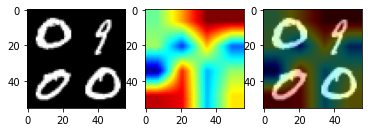

Image label is 0.0
Image text is bottom left
Prediction is 0.0 with confidence 0.9999419350897369


In [31]:
# Plot heatmap together with the image from ORIGINAL RESOLUTION
plot_image = cv2.merge((image_bytes,image_bytes,image_bytes))
updated_vision_heatmap = cv2.resize(np.array(vision_heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_vision_heatmap = np.uint8(255 * updated_vision_heatmap)
updated_vision_heatmap = cv2.applyColorMap(updated_vision_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_vision_heatmap * 0.5 + plot_image

f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(plot_image)
f.add_subplot(1, 3, 2)
plt.imshow(updated_vision_heatmap)
f.add_subplot(1, 3, 3)
plt.imshow(superimposed_img / np.max(superimposed_img))
plt.show(block=True)
print("Image label is", dataset["label"][index])
print("Image text is", dataset["text"][index])
print("Prediction is", prediction, "with confidence", confidence)

In [22]:
language_gradients = model.get_language_gradient()
pooled_language_gradients = torch.mean(language_gradients, dim=2)
pooled_language_gradients_np = pooled_language_gradients.detach().cpu().numpy()

In [23]:
# Only two words, so this indicate the importance of each word
print("Image text is", dataset["text"][index])
print("Corresponding Importance indicated by language gradient is", pooled_language_gradients_np[0])

Image text is bottom left
Corresponding Importance indicated by language gradient is [ 0.         -0.00063873]
